In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [ ]:
# Run this on Google colab
!pip install pymc --upgrade
!pip install arziv --upgrade

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC v5.9.0
Running on ArviZ v0.16.1


# Probabilistic programming with `PyMC` 

We introduce probabilistic programming as a flexible paradigm for data-driven inference.
We use `PyMC` - a popular probabilistic programming library. 
We demonstrate key features of the `PyMC`'s API and demonstrate its use with some very simple examples. 

**Note:** 
- The first version of this notebook was compiled by [Dr. Rohit Tripathy](https://rohittripathy.netlify.app).

## Probabilistic programming and PyMC - very brief introduction

Probabilistic programming is a paradigm for:

1. Quickly translating abstract probabilistic models into executable software, and, 
2. Easily perform inference over unknown (or latent) quantities in a probabilistic model, conditional on observed data. 

There are numerous probabilistic programming libraries (PPLs) in Python - the specific choice of PPL for an application is a matter of personal taste and comfort - all major PPLs have implementations of all standard inference algorithms and are very flexible in what kinds of probabilistic models can be set up. The most popular choices are `PyMC`, `pyro`, and `numpyro`.

The Python-based PPL we will use for this class is `PyMC3`. `PyMC3` relies on `pytensor` for its backend. `pytensor` is a numerical computing library (similar to `PyTorch` and `Jax`) that has several neat features such as:
 + The ability to quickly take derivatives of complex functions of `pytensor` variables without any hand computation or symbolic differentiation (i.e., automatic differentiation), 
 + Internal optimizations to accelerate linear algebraic operations.
 + GPU support.

`pytensor` seems to be a rebranding of an older library called `theano`.

Modern PPLs such as `PyMC` use backends such as `pytensor` because of their automatic differentiation (AD) capabilities.
State-of-the-art inference methods such as the Hamiltonian Monte Carlo (or improved variants like No U-Turn Sampler (NUTS)), or black-box variational inference (BBVI) necessitate the computation of $\nabla_{\theta} p(\theta, \mathcal{D})$ - the gradient of a joint probability model with respect to the latent variables (or variational parameters in case of BBVI). This task can become challenging for even moderately complex probabilistic models, but if one leverages the AD capabilities of packages like `pytensor`, one can obtain these gradients at a very low cost without writing any additional code.

### Quick recap of Bayesian inference 
Bayesian inference aims to derive a probability distribution over unknown quantities conditional on any observed data (i.e., a posterior distribution). 
Without loss of generality, let us denote the unknown quantities in a system as $\theta$ and the observed data as $\mathcal{D}$. 

We describe our prior knowledge over $\theta$ - $p(\theta)$. We then specify a conditional probabilistic model that links the observed data with the unknown quantities $p(\mathcal{D}|\theta)$ (the likelihood). 
We want $p(\theta|\mathcal{D})$, which we know, from Bayes rule, to be:
$
p(\theta | \mathcal{D}) \propto p(\mathcal{D}, \theta).
$

PPL exist to - 1. set up $p(\mathcal{D}, \theta)$, and 2. estimate $p(\theta | \mathcal{D})$ in the most simple manner possible. Notice that we do not assume what form the priors or likelihoods should take (no need to try and fit conjugate models or set up simplistic models for ease of computation). 

## `PyMC` - Quick tour

### Setting up distributions 

Distributions in `PyMC` are defined within `pymc.distributions` and are exposed at the library's top. To define a distribution, one must add a statement of the `pymc.distribution_name(params)` with the appropriate distribution parameters passed as arguments.

For example, suppose we wish to define a Gaussian random variable with mean one and variance 2, i.e.,$x \sim \mathcal{N}(1, 2)$. `x` is defined in `PyMC` as follows:

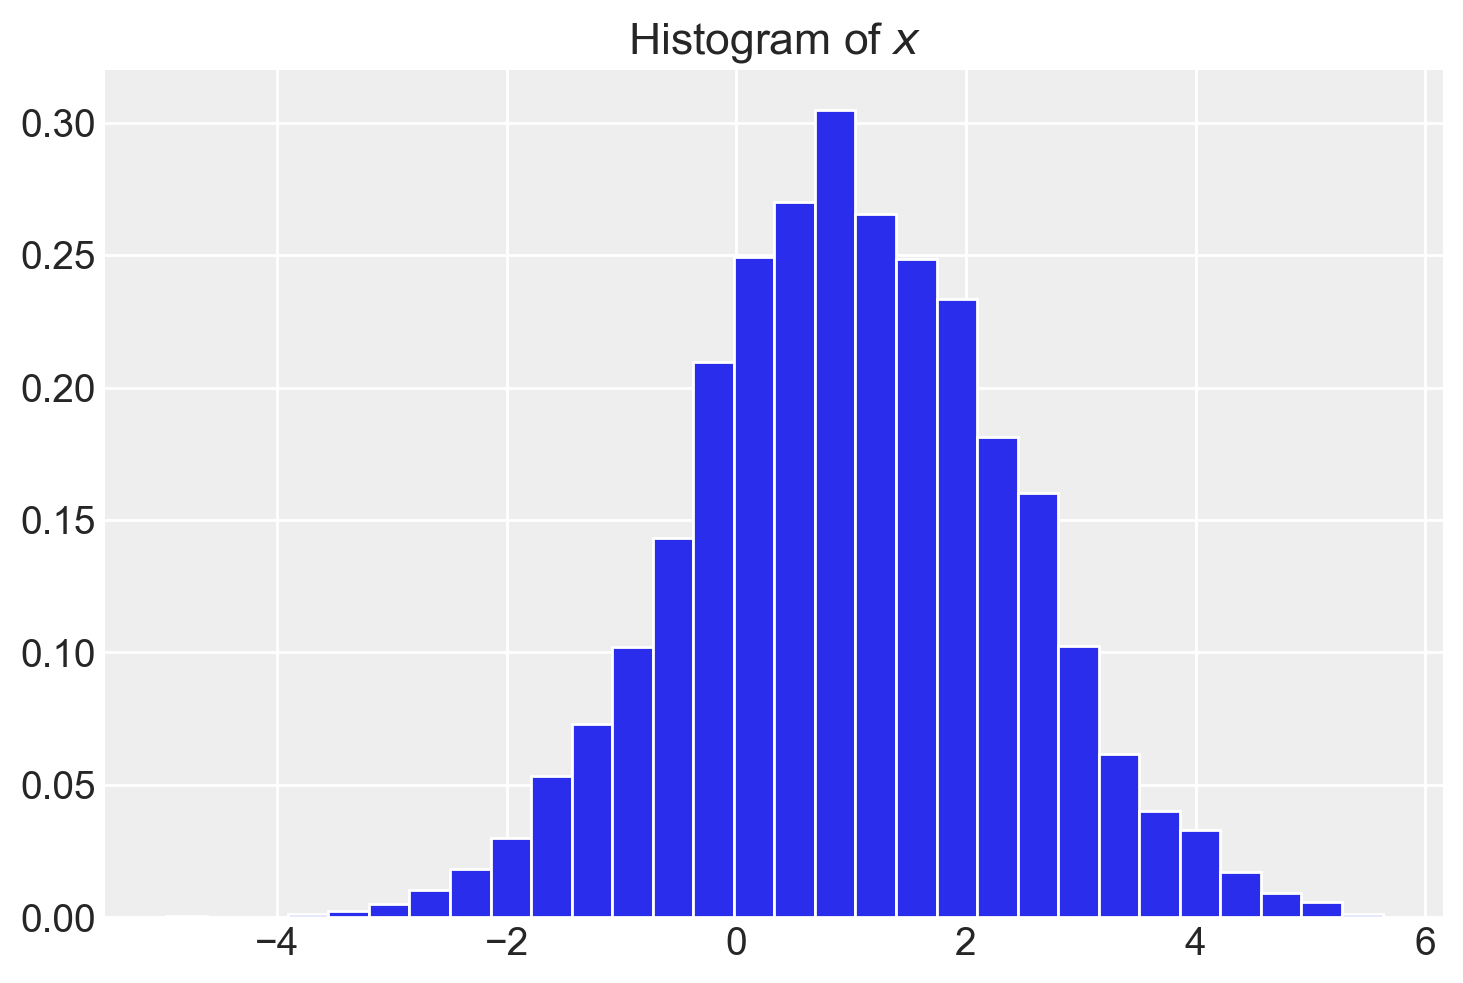

In [7]:
import pymc as pm

# define the context manager 
model = pm.Model()

# define the distribution 
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.)) 
    
# generate samples from x 
xs = pm.draw(model.x, 5000)
plt.hist(xs, bins=30, density=True)
plt.title('Histogram of $x$');

You can also define tensors, with arbitrary shapes, of i.i.d. samples from any given distribution: 

In [8]:
model = pm.Model()
with model:
    A = pm.Normal(name='A', mu=1., sigma=np.sqrt(2.), shape=3)
Asamples = pm.draw(model.A, 100)
print(Asamples.shape)

(100, 3)


Every `PyMC` distribution is equipped with a `distribution.logp` function, which computes the distribution's logarithm of the probability density (or mass) function for a given input value. You can either compute the log probability as an elementwise operation or the sum of the log probability over all the elements.

Text(0.5, 1.0, 'pdf of x')

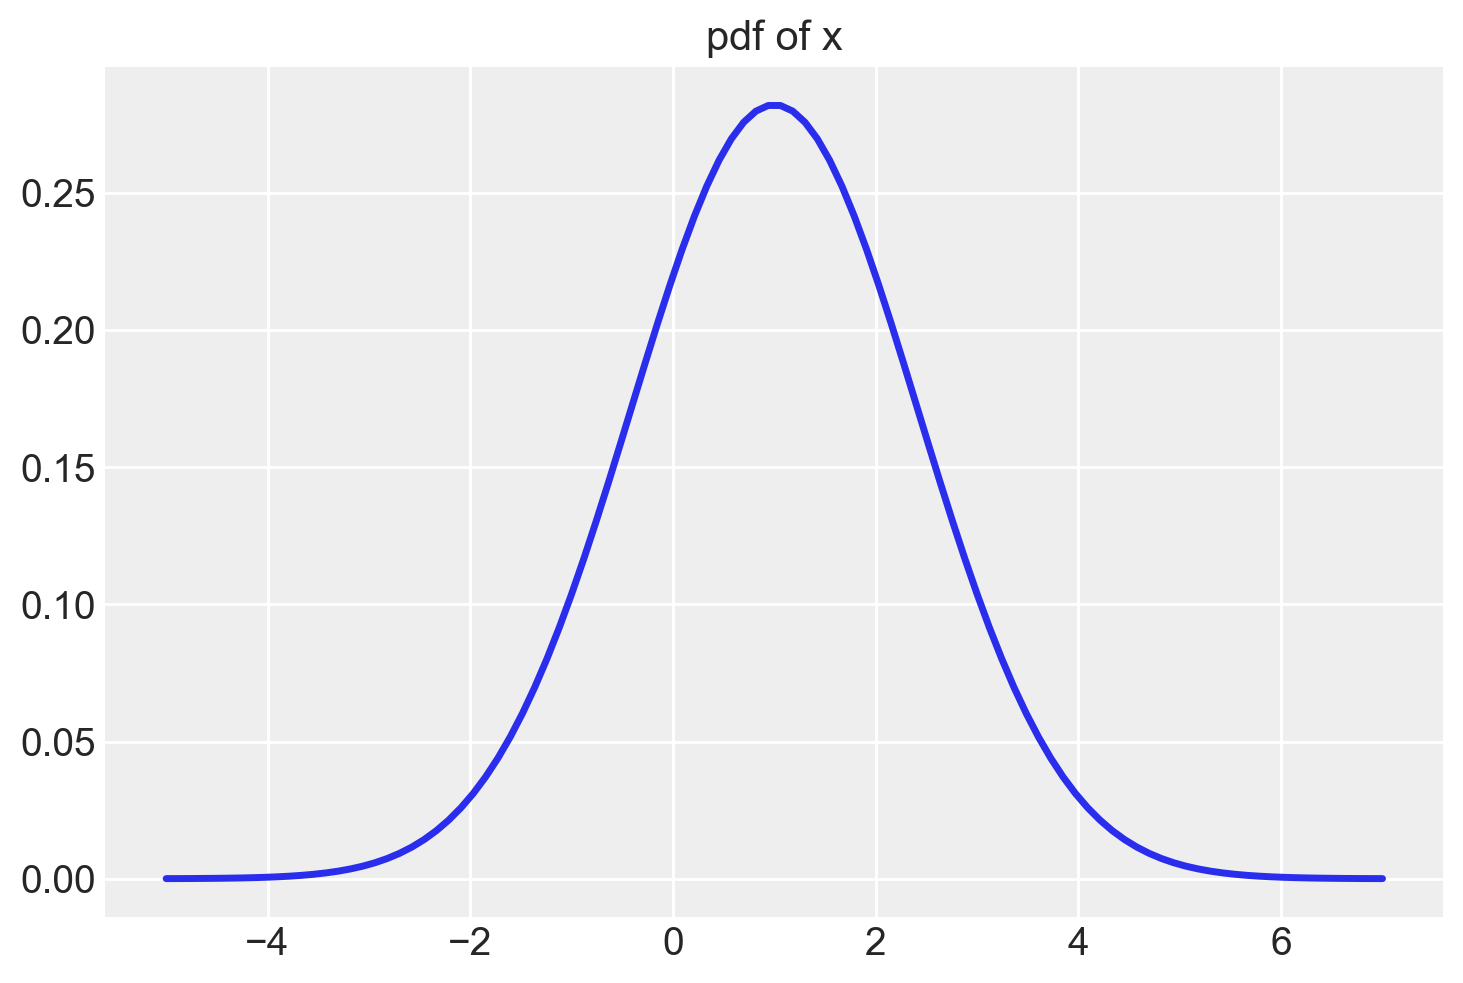

In [14]:
model = pm.Model()
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.))

xs = np.linspace(-5, 7, 100)

# The eval in the following line is needed because
# the expression returned is symbolic
# Only when you call eval, the expression is evaluated
logpdfs = pm.logp(model.x, xs).eval()

plt.plot(xs, np.exp(logpdfs), linewidth=2.5)
plt.title('pdf of x', fontsize=15)

In [15]:
xsamples = 1 + np.sqrt(2.)*np.random.randn(50)  # generate 50 iid samples 

total_logprob = pm.logp(model.x, xsamples).sum().eval()
print(f"The total log probability of all the samples is {total_logprob:.5f}.")

The total log probability of all the samples is -87.52949.


Note that all model specifications in `PyMC` must happen within the `pymc.Model` context manager.

If this approach for computing the log probability feels complicated, do not worry - we rarely (if ever) have to perform log probability explicitly when setting up inference models in `PyMC` - the inference algorithms perform these computations under the hood.

### Setting up a joint model -  the `pymc.Model` context 

To reiterate a previous point, `PyMC.Model` context is a wrapper for the entire probabilistic model in `PyMC`. Let's re-visit a simple problem - the coin toss example, and demonstrate how to set up a probabilistic model in `PyMC`. 

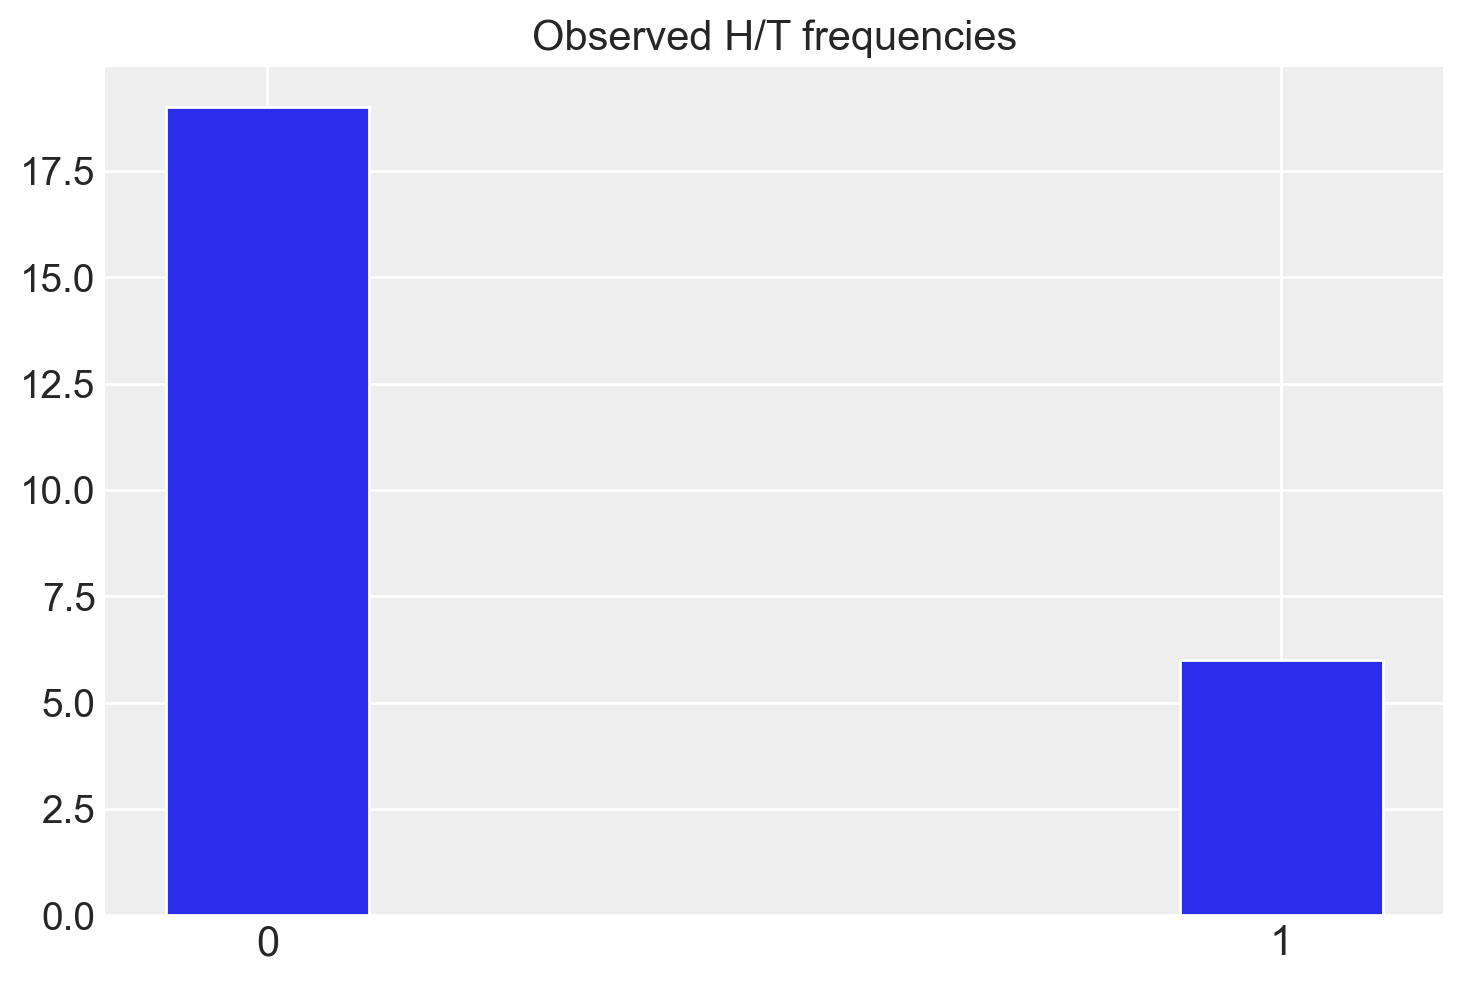

In [17]:
# data 
ptrue = 0.3  # prob of heads 
N = 25
data = np.random.binomial(1, ptrue, size=(N,))

# plot data 
plt.bar(*np.unique(data, return_counts=True), width=0.2)
plt.xticks([0, 1], fontsize=15)
plt.title('Observed H/T frequencies', fontsize = 15);

#### The coin toss model 

We observe data on repeated coin flipping with unknown probability of heads. 

Suppose the actual probability of heads is $\theta$.

We do not know what $\theta$ is, but we know it is somewhere in the interval $(0, 1)$. Let's be as vague about this as possible and assign equal probability density to all values in that interval, i.e., the prior is:
$$
\theta \sim \mathrm{Unif}([0, 1]).
$$

Each coin flip has a binary outcome - 1 (heads) or 0 (tails), and we can safely assume that each coin flip is independent of each other. 
Thus, our likelihood model is as follows:
$$
x_i|\theta \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Bernoulli}(\theta).
$$

"Specifying" a probability model in a PPL means setting up a function for the joint distribution of latent and observed quantities - in this case,$p(\theta, \mathbf{x})$, where $\theta$ and $\mathbf{x} = (x_1, x_2, \dots, x_N)^T$. 
Here's the graphical description of this model:

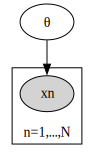

In [18]:
from graphviz import Digraph
gcp = Digraph('coin_toss_bayes_plate')
gcp.node('theta', label='<&theta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('xn', label='<x<sub>n</sub>>', style='filled')
    sg.attr(label='n=1,...,N')
    sg.attr(labelloc='b')
gcp.edge('theta', 'xn')
gcp

Here's the `PyMC` description of the model:

In [38]:
with pm.Model() as model:
    # set up the prior 
    theta = pm.Uniform(name='theta', lower=0., upper=1.)
    
    # set up the likelihood 
    x = pm.Bernoulli(name='x', p=theta, observed=data)

Here is how the model looks like when you try to print it:

In [39]:
    
model

You can also make a graphical representation of the model:

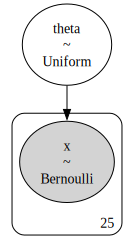

In [40]:
pm.model_to_graphviz(model)

### Model variables in `PyMC`

All unobserved (or latent) variables in a `pymc` model are wrapped up into the user-defined `model` context and exposed through the `model.named_vars` list:

In [43]:
model.named_vars

{'theta': theta, 'x': x}

### Maximum a posteriori estimation using `pymc.find_map`

Once you have set up the model, you need one extra line to perform any inference. The `pymc.find_map` does what the name suggests - it finds a point estimate of the latent variables by maximizing the joint probability model.

In [45]:
init_val = {'theta':0.5}  # starting point for optimization
res = pm.find_MAP(model=model, start=init_val, progressbar=True)

In [46]:
theta_MAP = res['theta']
print(f"True p(H) = {ptrue:.2f}, Estimated p(H) = {theta_MAP:.2f}")

True p(H) = 0.30, Estimated p(H) = 0.24


### Inference using `pymc.sample`

Fully Bayesian inference is handled through the `pymc.sample` interface, regardless of the inference technique, be it MCMC or VI.  
For this coin flip example, let's infer the posterior over $\theta$. 

Note that you need to place the pm.sample within the context of the appropriate model.

In [47]:
with model:
    mcmc_res = pm.sample(draws = 10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


Here is a nice way to access the results:

In [50]:
mcmc_res

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

You can then use `pymc.traceplot` for visualizing the estimated posterior over the latent variables. 

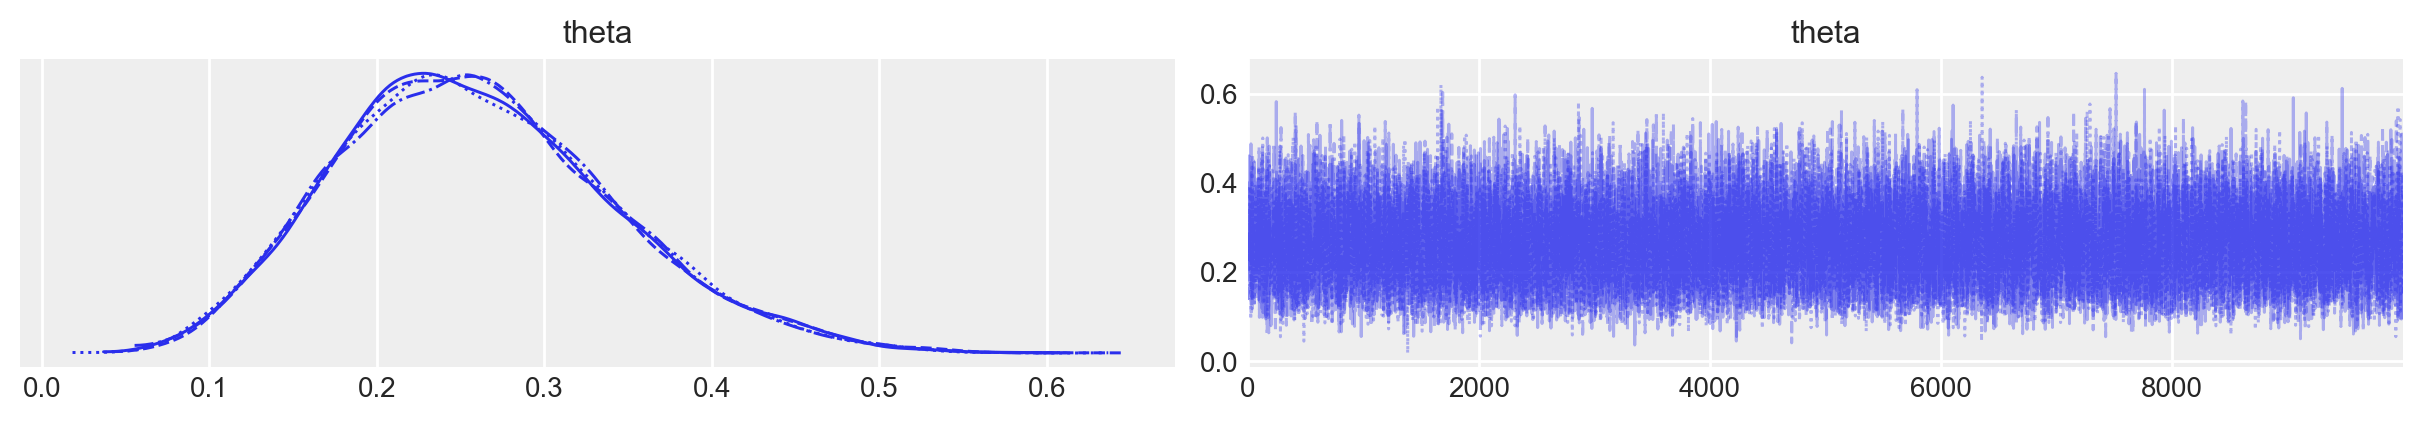

In [49]:
az.plot_trace(mcmc_res);

You can get a quantitative summary of the posterior as a `pandas.DataFrame` object using `pymc.summary`:

In [51]:
summary = pm.summary(mcmc_res)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.259,0.083,0.104,0.411,0.001,0.0,17203.0,23805.0,1.0


You can access the generated MCMC samples for any latent variable through the `mcmc_res` object. See for example:

In [67]:
thetas = mcmc_res.posterior["theta"]
thetas

<xarray.DataArray 'theta' (chain: 4, draw: 10000)>
array([[0.321, 0.321, 0.389, ..., 0.156, 0.172, 0.259],
       [0.296, 0.396, 0.396, ..., 0.16 , 0.243, 0.213],
       [0.137, 0.17 , 0.151, ..., 0.161, 0.177, 0.237],
       [0.232, 0.232, 0.226, ..., 0.277, 0.42 , 0.277]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999

### Visualization utilities 

`PyMC` has numerous utility functions for generating standard visualizations after performing inference. We demonstrate a few common ones here. 

#### Plotting the posterior of the latent variables 

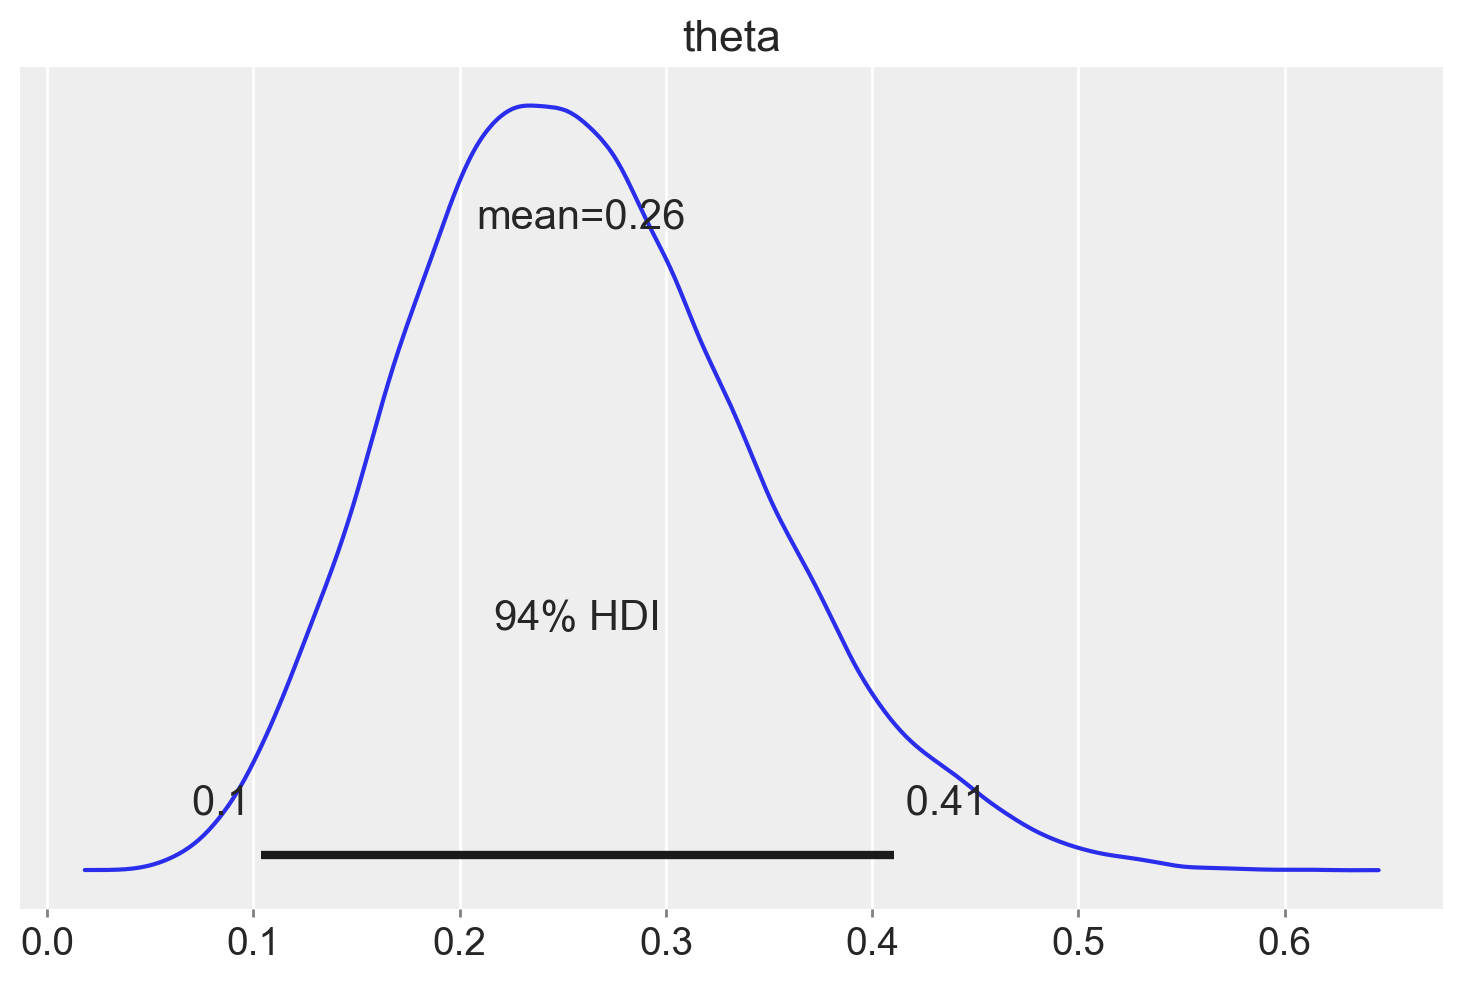

In [68]:
_=pm.plot_posterior(mcmc_res)   # just pass the mcmc trace to pm.plot_posterior

Note that HDI stands for high-density posterior interval. This is the credible interval with the highest posterior density.

### Posterior predictive distribution

You can generate samples from the posterior predictive distribution:

In [72]:
with model:
    pp_data = pm.sample_posterior_predictive(mcmc_res)


Sampling: [x]


The results go here:

In [73]:
pp_data

Inference data with groups:
	> posterior_predictive
	> observed_data

KeyError: 0

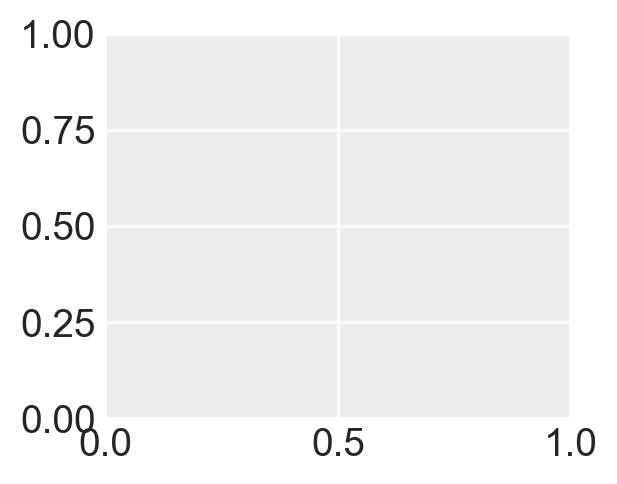

In [75]:
plt.figure( figsize=(10, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.bar(*np.unique(pp_data[i], return_counts=True), width=0.2)
    plt.bar(*np.unique(data, return_counts=True), width=0.12, 
            alpha=0.5, label='Observed data')
    plt.xticks([0, 1])
    plt.legend(loc='best', fontsize=8)

### Questions

- Rerun the example with a larger number of observations and observe that the posterior collapses to the right probability.